# Interpret results of Predictive modelling of stroke occurences

Import libraries

In [2]:
import pandas as pd
from utils import Performance, InterpretModel
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report, confusion_matrix

c:\Users\Bruger\anaconda3\envs\datascience\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load data and models

In [3]:
# Load models for reproducing the results
import joblib
best_grid = joblib.load("./models/random_forest_best.joblib")
best_random = joblib.load("./models/random_forest_RandomSearch.joblib")
rf = joblib.load("./models/random_forest_original.joblib")
XGB = joblib.load("./models/XGB_model.joblib")
from keras.models import load_model
model = load_model('models/ANN_model.h5')
best_grid = joblib.load("./models/random_forest_best.joblib")
X_train = pd.read_pickle("data/X_train.pkl")
X_test = pd.read_pickle("data/X_test.pkl")
y_test = pd.read_pickle("data/y_test.pkl")
performance = Performance()

### ANN performance

32/32 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.98      0.74      0.85       971
           1       0.14      0.76      0.23        51

    accuracy                           0.74      1022
   macro avg       0.56      0.75      0.54      1022
weighted avg       0.94      0.74      0.82      1022



[Text(0.5, 15.0, 'Predicted condition'), Text(33.0, 0.5, 'Actual condition')]

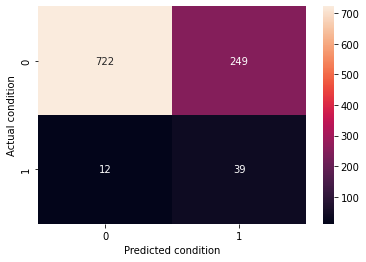

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
#Predictions
prediction_values = model.predict(X_test_scaled)
# Convert into classes 
prediction = []
for i in prediction_values:
    prediction.append(np.where(i > 0.5, 1,0)[0])

print(classification_report(y_test,prediction))

cf = confusion_matrix(y_test,prediction)
import seaborn as sns
s = sns.heatmap(cf, annot=True, fmt='g')
s.set(xlabel='Predicted condition', ylabel='Actual condition')

### XGBoost


              precision    recall  f1-score   support

           0       0.98      0.70      0.82       971
           1       0.12      0.76      0.20        51

    accuracy                           0.70      1022
   macro avg       0.55      0.73      0.51      1022
weighted avg       0.94      0.70      0.79      1022


Model Performance
Accuracy = 70.25%.
Recall strokes only = 76.47%.


[Text(0.5, 15.0, 'Predicted condition'), Text(33.0, 0.5, 'Actual condition')]

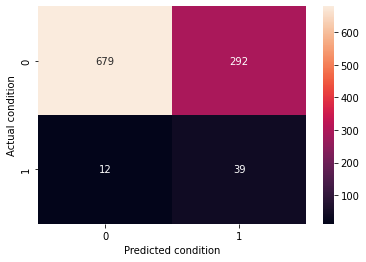

In [5]:
y_pred = XGB.predict(X_test) # Make predictions
print(classification_report(y_test,y_pred))
print()
cf = confusion_matrix(y_test,y_pred)
XGB_performance = performance.evaluate(test_labels = y_test, predictions = y_pred)
s = sns.heatmap(cf, annot=True, fmt='g')
s.set(xlabel='Predicted condition', ylabel='Actual condition')

### Random Forest

### Tuned Random Forest via Random Search

              precision    recall  f1-score   support

           0       0.99      0.73      0.84       971
           1       0.14      0.82      0.24        51

    accuracy                           0.73      1022
   macro avg       0.56      0.78      0.54      1022
weighted avg       0.95      0.73      0.81      1022




[Text(0.5, 15.0, 'Predicted condition'), Text(33.0, 0.5, 'Actual condition')]

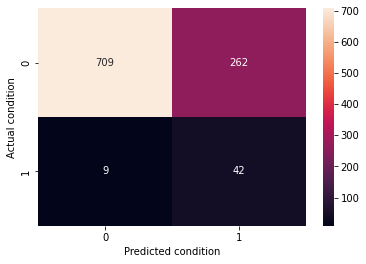

In [6]:
preds = best_random.predict(X_test)
print(classification_report(y_test,preds))
print()
cf = confusion_matrix(y_test,preds)
s = sns.heatmap(cf, annot=True, fmt='g')
s.set(xlabel='Predicted condition', ylabel='Actual condition')

#### Tuned Random Forest via Grid search 

Evaluate the performance of the grid search

              precision    recall  f1-score   support

           0       0.99      0.73      0.84       971
           1       0.14      0.82      0.24        51

    accuracy                           0.73      1022
   macro avg       0.56      0.78      0.54      1022
weighted avg       0.95      0.73      0.81      1022


Model Performance
Accuracy = 73.39%.
Recall strokes only = 82.35%.


[Text(0.5, 15.0, 'Predicted condition'), Text(33.0, 0.5, 'Actual condition')]

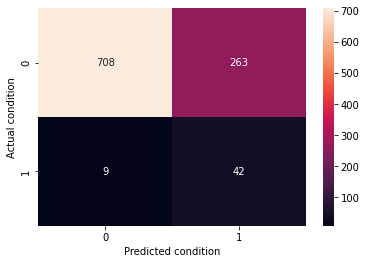

In [7]:
preds = best_grid.predict(X_test)
print(classification_report(y_test,preds))
print()
cf = confusion_matrix(y_test,preds)
RF_performance = performance.evaluate(test_labels = y_test, predictions = preds)
s = sns.heatmap(cf, annot=True, fmt='g')
s.set(xlabel='Predicted condition', ylabel='Actual condition')

### Lowering the threshold

              precision    recall  f1-score   support

           0       0.99      0.64      0.78       971
           1       0.12      0.88      0.20        51

    accuracy                           0.66      1022
   macro avg       0.55      0.76      0.49      1022
weighted avg       0.95      0.66      0.75      1022



[Text(0.5, 15.0, 'Predicted condition'), Text(33.0, 0.5, 'Actual condition')]

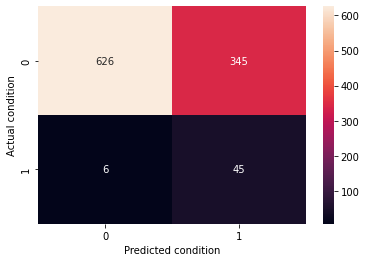

In [8]:
prediction_values = best_grid.predict_proba(X_test) 

threshold = 0.4
predicted = (prediction_values [:,1] >= threshold).astype('int')

print(classification_report(y_test, predicted))

cf__new_threshhold = confusion_matrix(y_test,predicted)
s = sns.heatmap(cf__new_threshhold, annot=True, fmt='g')
s.set(xlabel='Predicted condition', ylabel='Actual condition')


# Interpretation

In [9]:
# Best grid search and the best random model were almost the same. I go with the best random search model for now
model_interpret = best_random

In [10]:
# Prep data
interpreter = InterpretModel(X_test, y_test)

# Filter out strokes instances
strokes_X_test, strokes_y_test = interpreter.prepare_data()

# Apply LIME
interpreter.LIME_method(model_interpret, X_train, strokes_X_test, strokes_y_test, 0, 51)


<!-- http://127.0.0.1:7081/1702406604208/ -->

In [11]:
# Apply SHAP globally
interpreter.SHAP_method(best_grid, X_test, 0, 1022)

The RandomForestClassifier(max_depth=100, min_samples_leaf=2, min_samples_split=4,
                       n_estimators=1500) predicted: 0


In [12]:
# Apply SHAP on one instance
interpreter.SHAP_method(best_grid, strokes_X_test, 40, 41)

The RandomForestClassifier(max_depth=100, min_samples_leaf=2, min_samples_split=4,
                       n_estimators=1500) predicted: 1


In [13]:
# Apply SHAP on one instance
interpreter.SHAP_method(best_grid, strokes_X_test, 41, 42)

The RandomForestClassifier(max_depth=100, min_samples_leaf=2, min_samples_split=4,
                       n_estimators=1500) predicted: 0
